In [23]:
import sys
import itertools
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split 
from statsmodels.tsa.api import VAR

In [24]:
 # Corn, Wheat, Soybean Futures Data
tickers = ['ZC=F', 'ZW=F', 'ZS=F'] 

In [25]:
# Take Yearly Data
years = [
    ("2001-01-01", "2002-01-01"),
    ("2002-01-01", "2003-01-01"),
    ("2003-01-01", "2004-01-01"),
    ("2004-01-01", "2005-01-01"),
    ("2005-01-01", "2006-01-01"),
    ("2006-01-01", "2007-01-01"),
    ("2007-01-01", "2008-01-01"),
    ("2008-01-01", "2009-01-01"),
    ("2009-01-01", "2010-01-01"),
    ("2010-01-01", "2011-01-01"),
    ("2011-01-01", "2012-01-01"),
    ("2012-01-01", "2013-01-01"),
    ("2013-01-01", "2014-01-01"),
    ("2014-01-01", "2015-01-01"),
    ("2015-01-01", "2016-01-01"),
    ("2016-01-01", "2017-01-01"),
    ("2017-01-01", "2018-01-01"),
    ("2018-01-01", "2019-01-01"),
    ("2019-01-01", "2020-01-01"),
    ("2020-01-01", "2021-01-01"),
    ("2021-01-01", "2022-01-01"),
    ("2022-01-01", "2023-01-01"),
    ("2023-01-01", "2024-01-01"),
    ("2024-01-01", "2025-01-01")
]

In [26]:
# Dictionary to store yearly data
years_to_closes = {}

# Iterating over the years to gain data for each incremental calender year
for start_date, end_date in years:
    closes = yf.download(tickers, start_date, end_date)["Close"]
    years_to_closes[(start_date, end_date)] = closes


/var/folders/wv/zhy7jwd11yjbz36c868w9c040000gn/T/ipykernel_70903/3701682953.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  closes = yf.download(tickers, start_date, end_date)["Close"]
[*********************100%***********************]  3 of 3 completed
/var/folders/wv/zhy7jwd11yjbz36c868w9c040000gn/T/ipykernel_70903/3701682953.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  closes = yf.download(tickers, start_date, end_date)["Close"]
[*********************100%***********************]  3 of 3 completed
/var/folders/wv/zhy7jwd11yjbz36c868w9c040000gn/T/ipykernel_70903/3701682953.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  closes = yf.download(tickers, start_date, end_date)["Close"]
[*********************100%***********************]  3 of 3 completed
/var/folders/wv/zhy7jwd11yjbz36c868w9c040000gn/T/ipykernel_70903/3701682953.py:6: FutureWarning: YF.download() has changed a

In [27]:
train_test_closes = {}

for year, closes in years_to_closes.items():
   
    # Split the closes data into train and test sets (80% train, 20% test by default)
    train_data, test_data = train_test_split(closes, test_size=0.2, shuffle=False)
    
    print(closes)
    # Store the result in the new dictionary
    train_test_closes[year] = {
        'train': train_data.dropna(),
        'test': test_data.dropna()
    }

Ticker        ZC=F    ZS=F    ZW=F
Date                              
2001-01-02  222.50  500.00  277.25
2001-01-03     NaN  493.75  275.75
2001-01-04     NaN  499.50  283.00
2001-01-05     NaN  493.75  284.25
2001-01-08     NaN  488.00  281.25
...            ...     ...     ...
2001-12-24  203.50  435.50  288.75
2001-12-26  199.75     NaN     NaN
2001-12-27  202.00  428.75  288.50
2001-12-28  200.75  428.50  292.50
2001-12-31  199.75  423.75  291.00

[251 rows x 3 columns]
Ticker        ZC=F    ZS=F    ZW=F
Date                              
2002-01-02  199.50  422.75  292.00
2002-01-03  202.00  418.50  292.25
2002-01-04  202.50  423.50  301.00
2002-01-07  203.50  428.00  308.00
2002-01-08  204.00  430.00  304.50
...            ...     ...     ...
2002-12-24  242.75  572.75  345.75
2002-12-26  242.75  565.75  338.25
2002-12-27  239.75  569.75  333.00
2002-12-30  235.75  565.75  329.00
2002-12-31  235.75  569.50  325.00

[252 rows x 3 columns]
Ticker        ZC=F    ZS=F    ZW=F
Date   

In [28]:
var_year_to_models = {}
max_lag = 4          # search VAR(1)...VAR(4)
h = 21               # ~1 trading month horizon
years_sorted = sorted(train_test_closes.keys())

for year in years_sorted:
    print(f"\n=== Training VAR on year: {year} ===")

    train_df = train_test_closes[year]['train'][tickers].dropna()

    best_aic = np.inf
    best_p = None
    best_res = None

    for p in range(1, max_lag + 1):
        try:
            model = VAR(train_df)
            res = model.fit(p)

            if res.aic < best_aic:
                best_aic = res.aic
                best_p = p
                best_res = res
        except Exception as e:
            print(f"  p={p} failed for {year}: {e}")
            continue

    var_year_to_models[year] = {
        "lag_order": best_p,
        "aic": best_aic,
        "model": best_res,
    }

    print(f"  Best VAR order for {year}: p={best_p}, AIC={best_aic:.3f}")

/opt/anaconda3/envs/comp3200/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/comp3200/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/comp3200/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/comp3200/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so


=== Training VAR on year: ('2001-01-01', '2002-01-01') ===
  Best VAR order for ('2001-01-01', '2002-01-01'): p=2, AIC=8.248

=== Training VAR on year: ('2002-01-01', '2003-01-01') ===
  Best VAR order for ('2002-01-01', '2003-01-01'): p=1, AIC=9.212

=== Training VAR on year: ('2003-01-01', '2004-01-01') ===
  Best VAR order for ('2003-01-01', '2004-01-01'): p=1, AIC=9.782

=== Training VAR on year: ('2004-01-01', '2005-01-01') ===
  Best VAR order for ('2004-01-01', '2005-01-01'): p=2, AIC=12.456

=== Training VAR on year: ('2005-01-01', '2006-01-01') ===
  Best VAR order for ('2005-01-01', '2006-01-01'): p=1, AIC=9.437

=== Training VAR on year: ('2006-01-01', '2007-01-01') ===
  Best VAR order for ('2006-01-01', '2007-01-01'): p=2, AIC=10.282

=== Training VAR on year: ('2007-01-01', '2008-01-01') ===
  Best VAR order for ('2007-01-01', '2008-01-01'): p=1, AIC=13.765

=== Training VAR on year: ('2008-01-01', '2009-01-01') ===
  Best VAR order for ('2008-01-01', '2009-01-01'): p=2,

/opt/anaconda3/envs/comp3200/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/comp3200/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/comp3200/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/comp3200/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so


=== VAR month-ahead forecast: ('2001-01-01', '2002-01-01'), VAR(2) ===


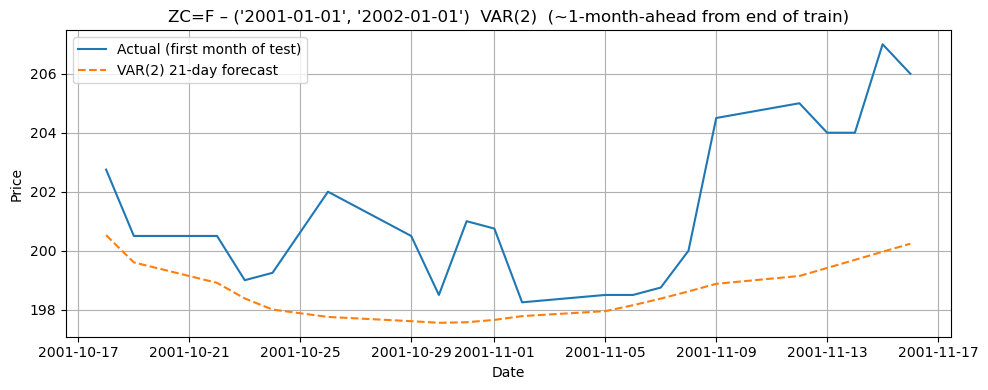

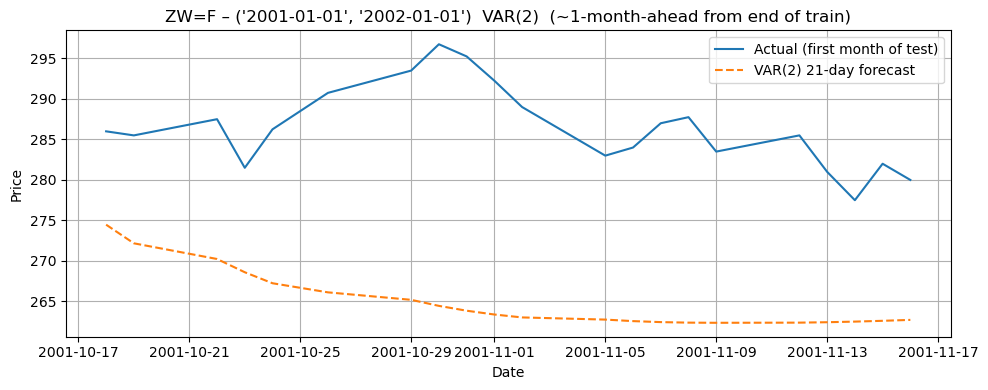

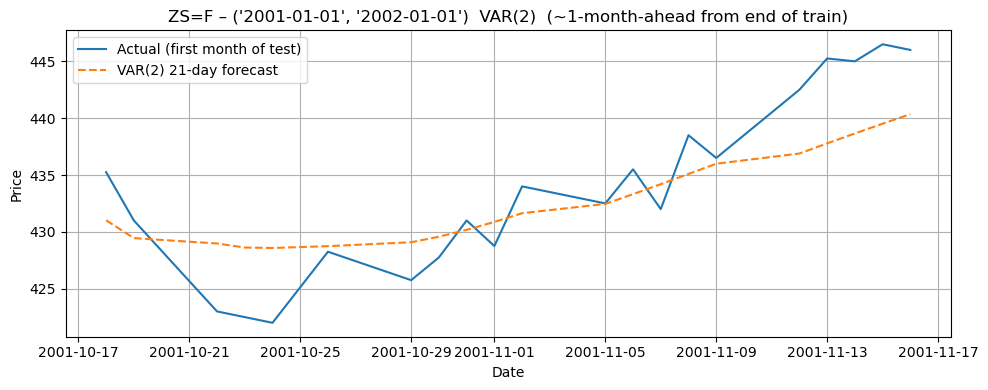


=== VAR month-ahead forecast: ('2002-01-01', '2003-01-01'), VAR(1) ===


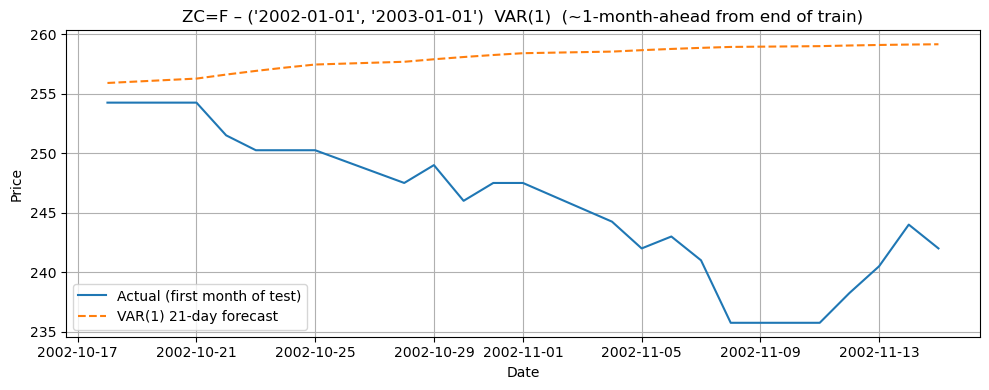

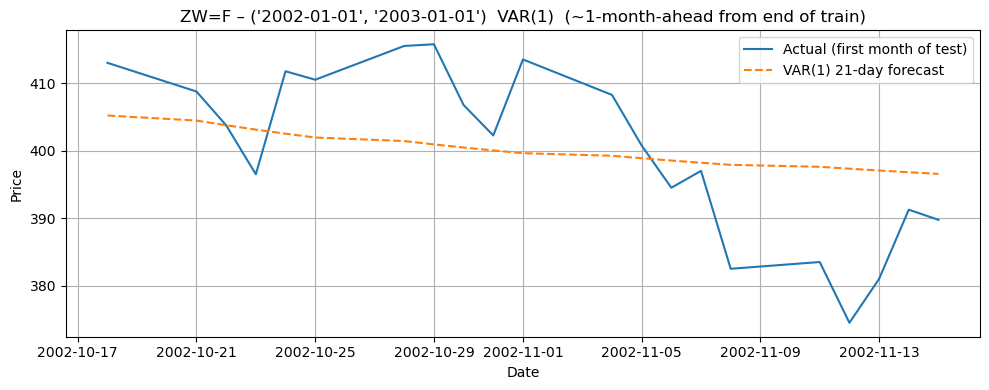

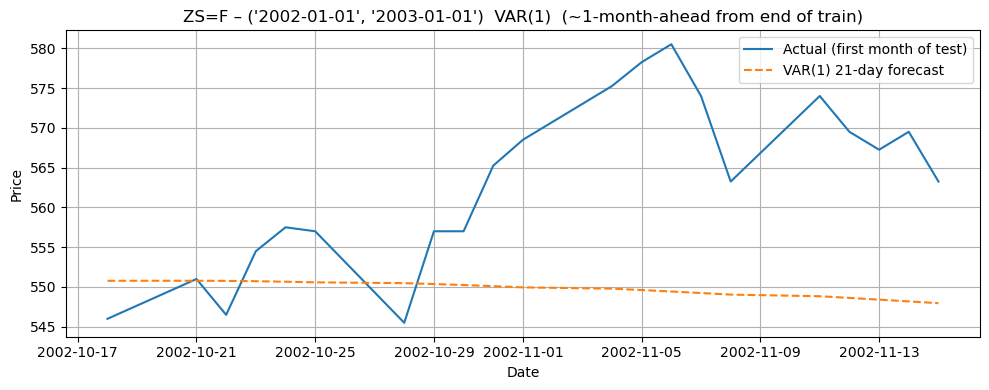


=== VAR month-ahead forecast: ('2003-01-01', '2004-01-01'), VAR(1) ===


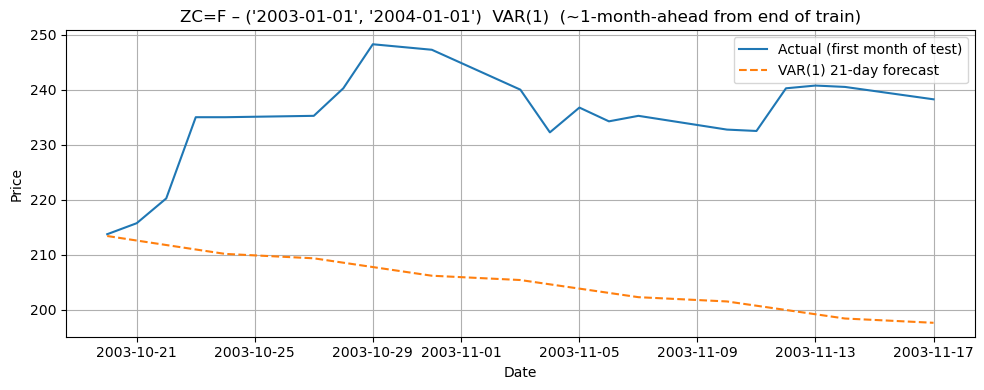

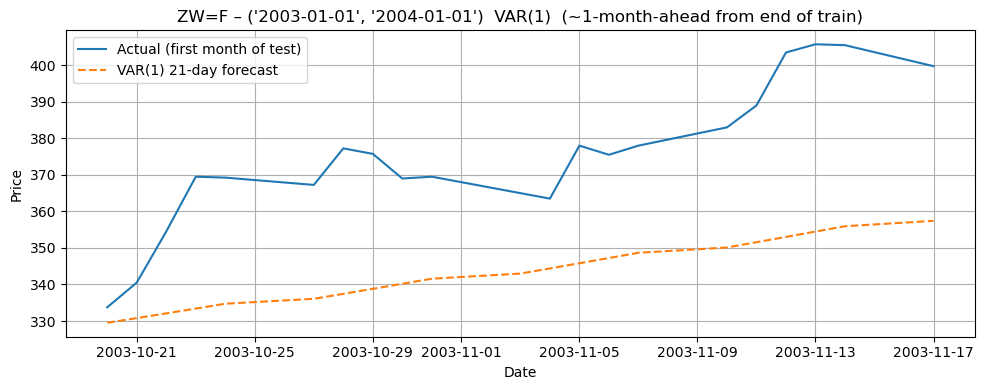

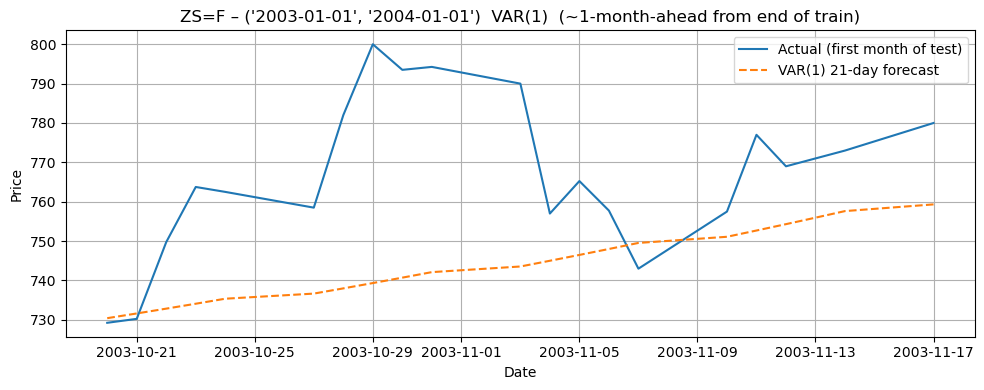


=== VAR month-ahead forecast: ('2004-01-01', '2005-01-01'), VAR(2) ===


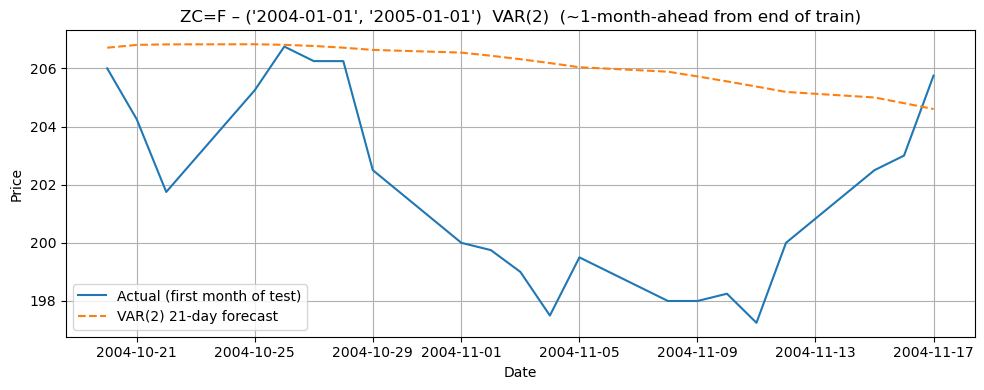

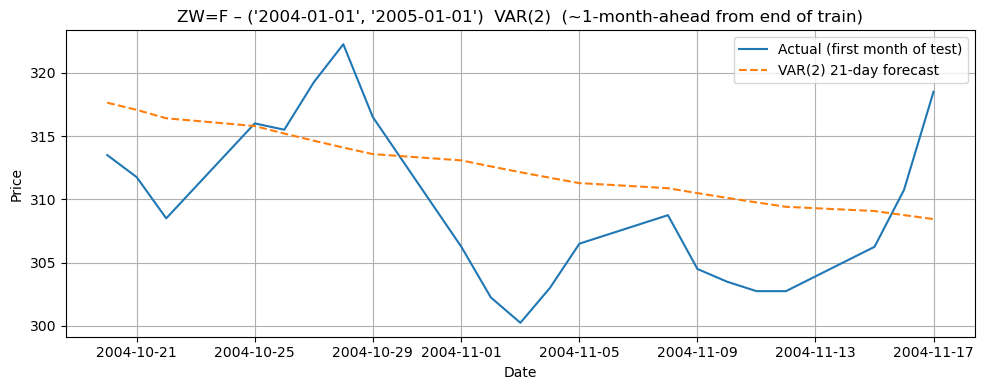

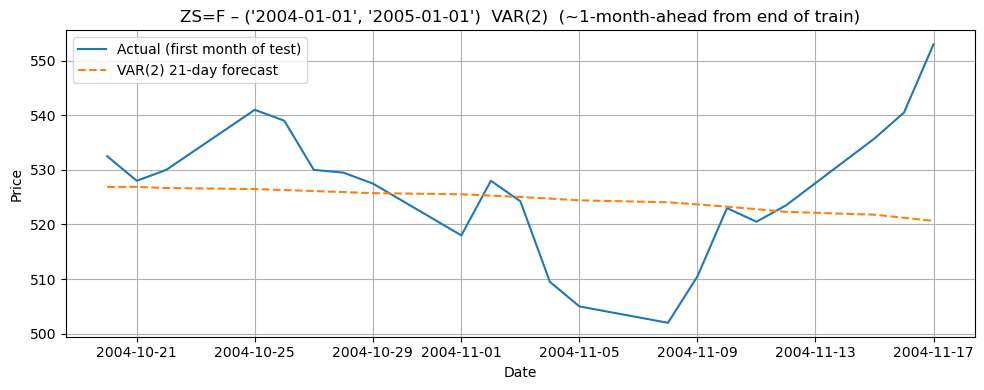


=== VAR month-ahead forecast: ('2005-01-01', '2006-01-01'), VAR(1) ===


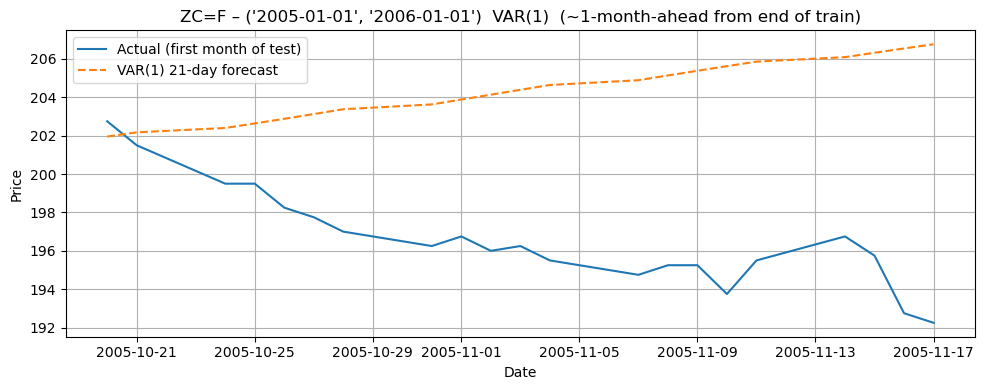

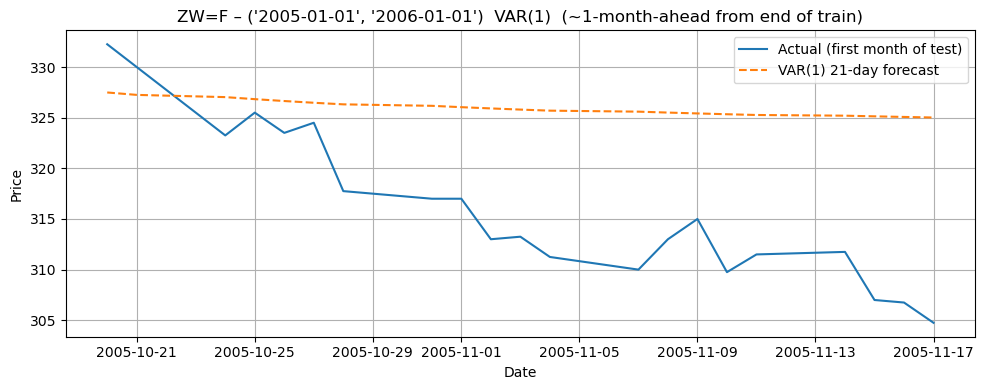

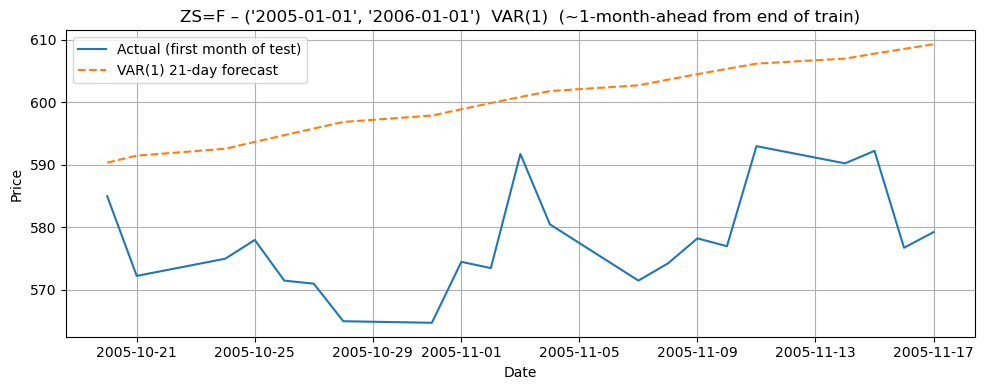


=== VAR month-ahead forecast: ('2006-01-01', '2007-01-01'), VAR(2) ===


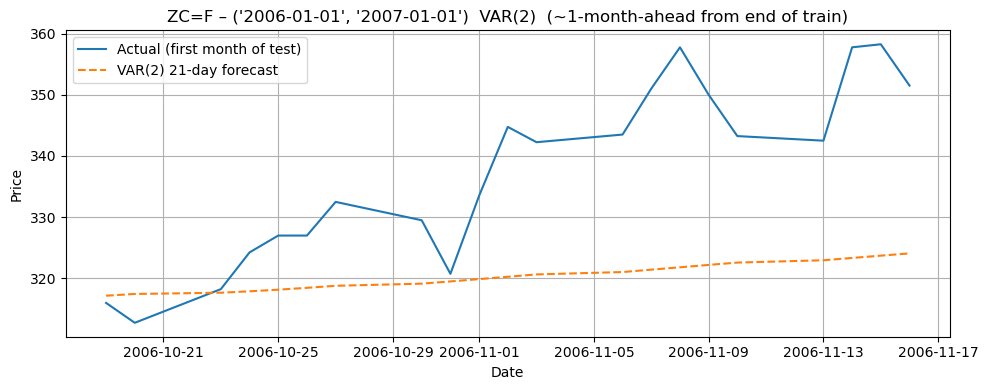

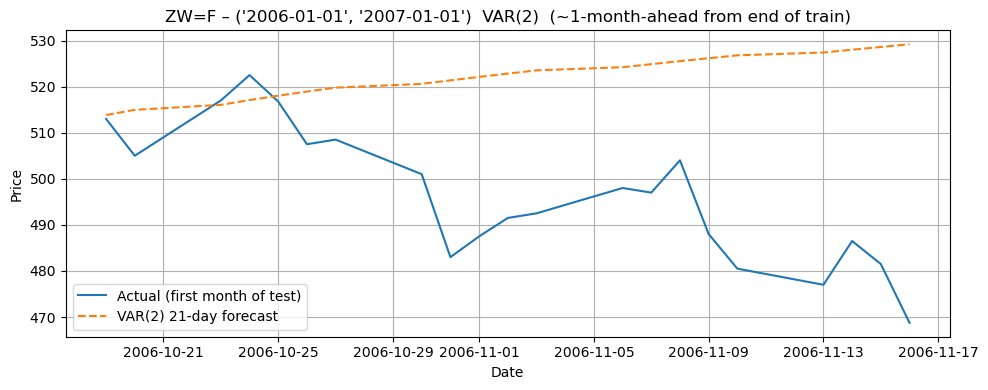

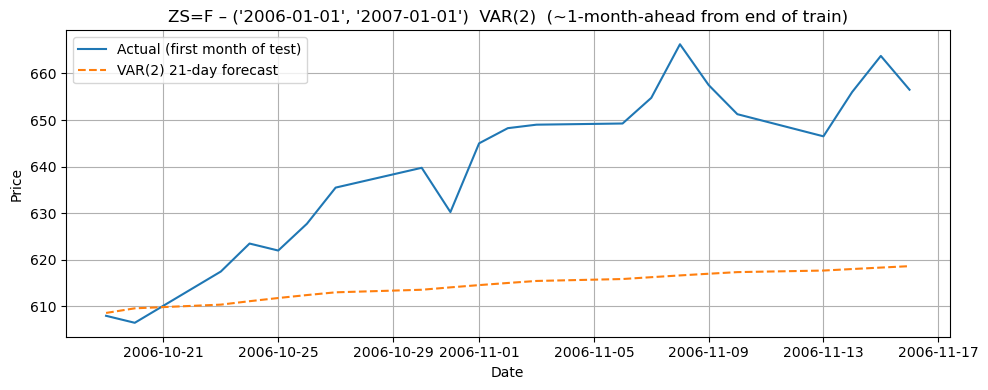


=== VAR month-ahead forecast: ('2007-01-01', '2008-01-01'), VAR(1) ===


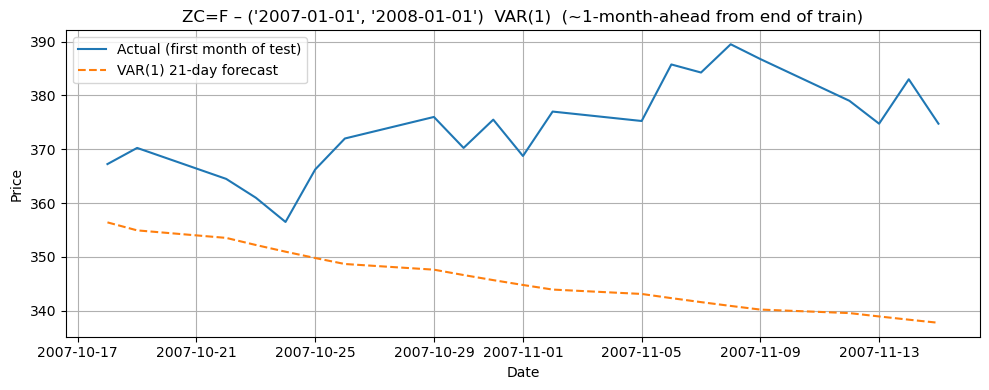

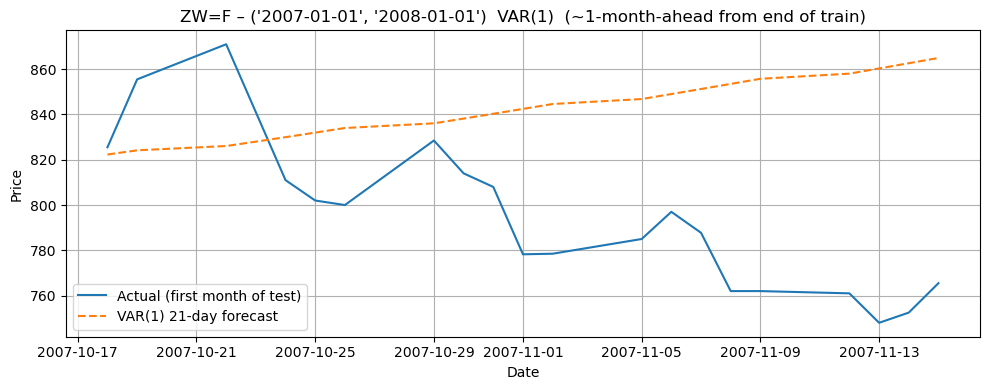

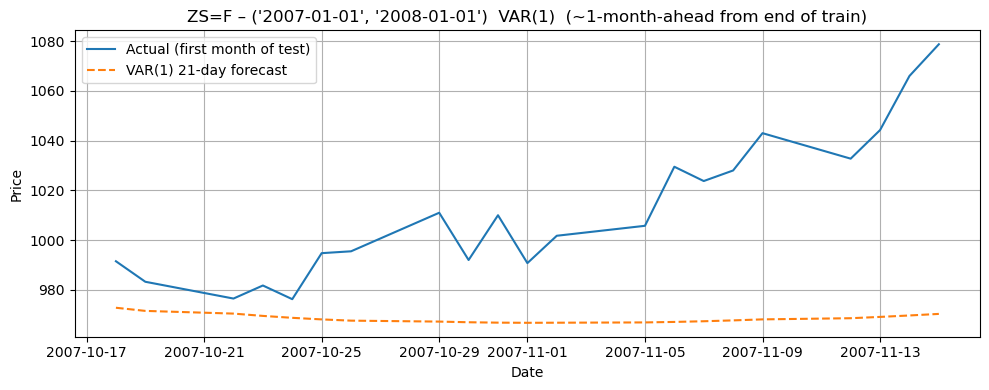


=== VAR month-ahead forecast: ('2008-01-01', '2009-01-01'), VAR(2) ===


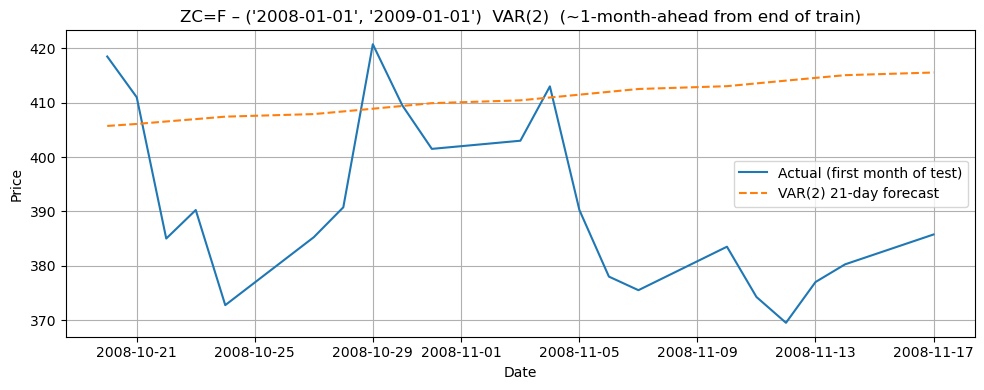

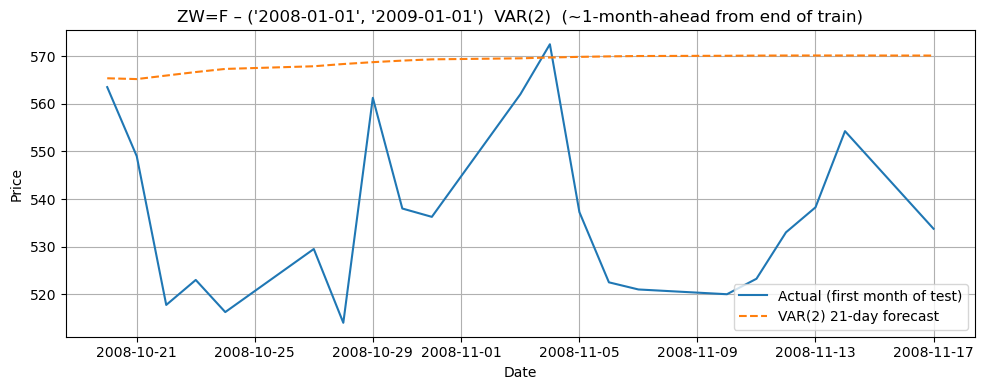

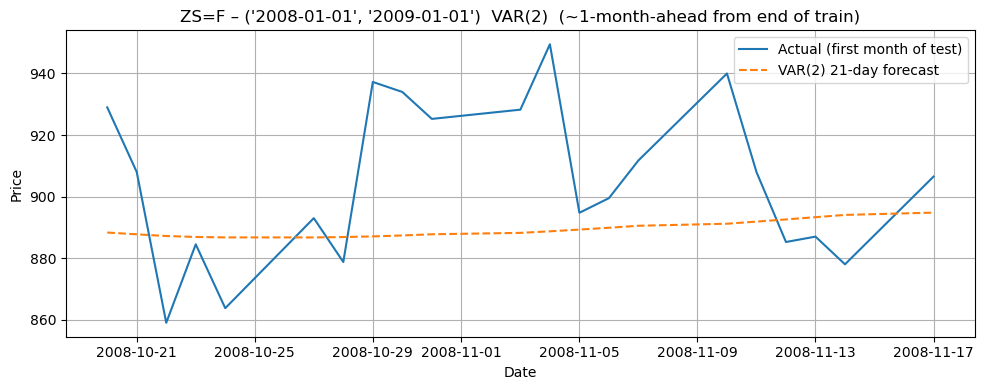


=== VAR month-ahead forecast: ('2009-01-01', '2010-01-01'), VAR(1) ===


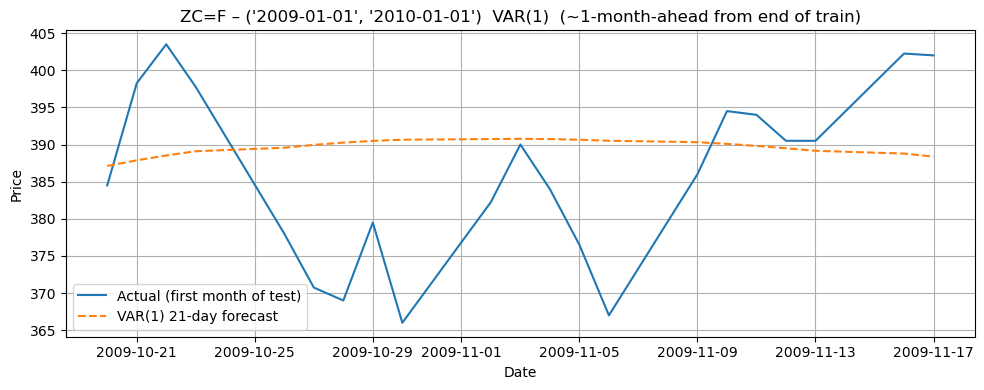

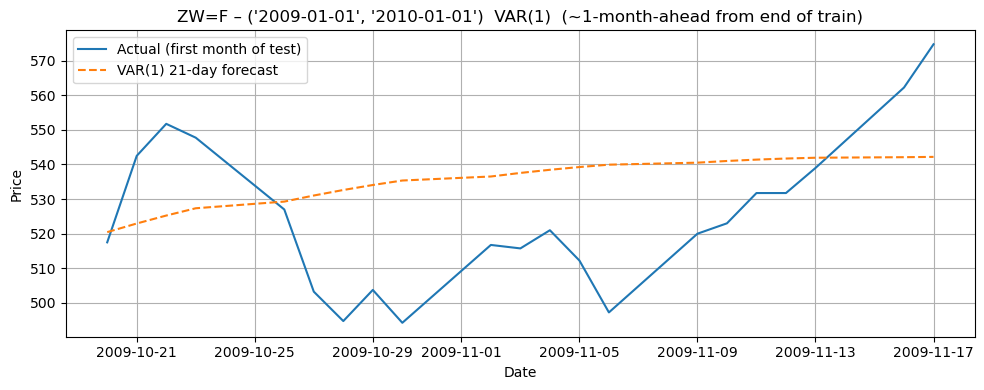

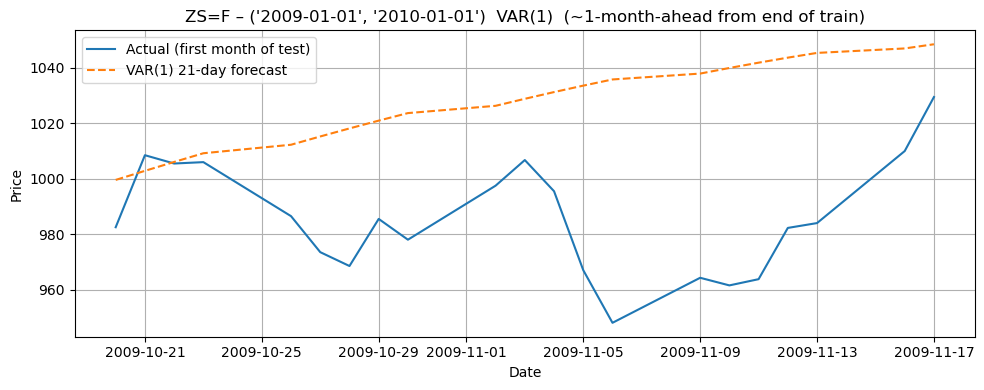


=== VAR month-ahead forecast: ('2010-01-01', '2011-01-01'), VAR(1) ===


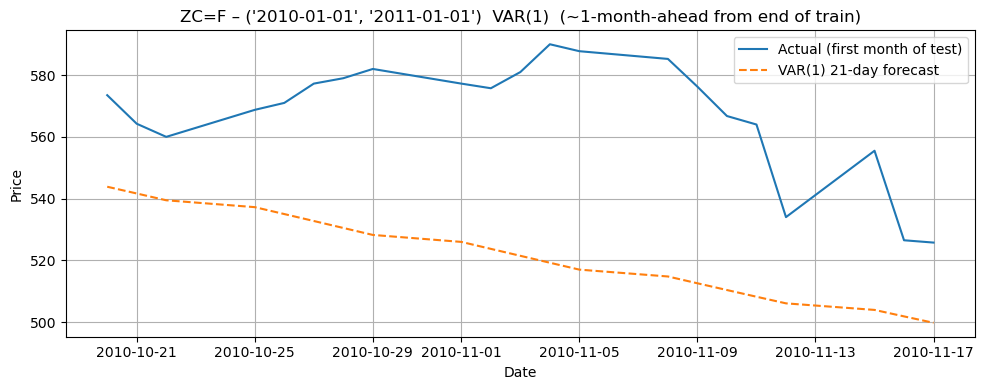

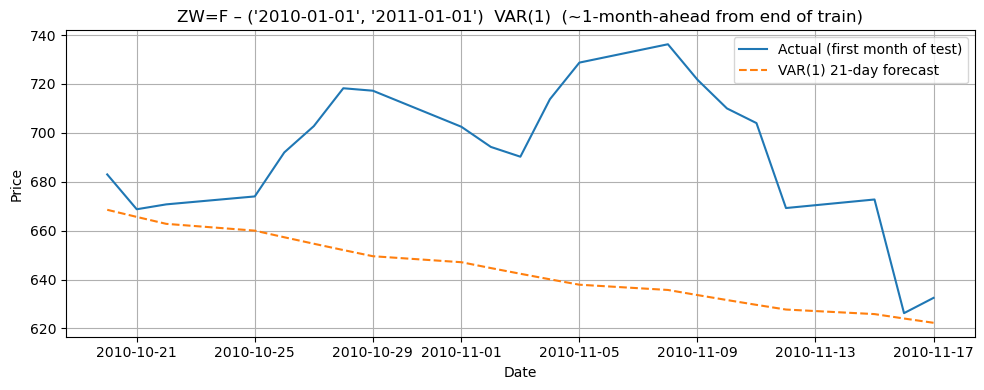

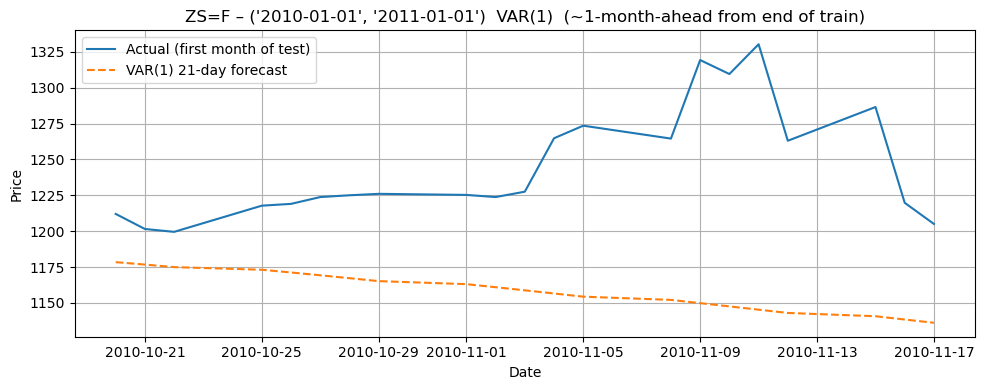


=== VAR month-ahead forecast: ('2011-01-01', '2012-01-01'), VAR(1) ===


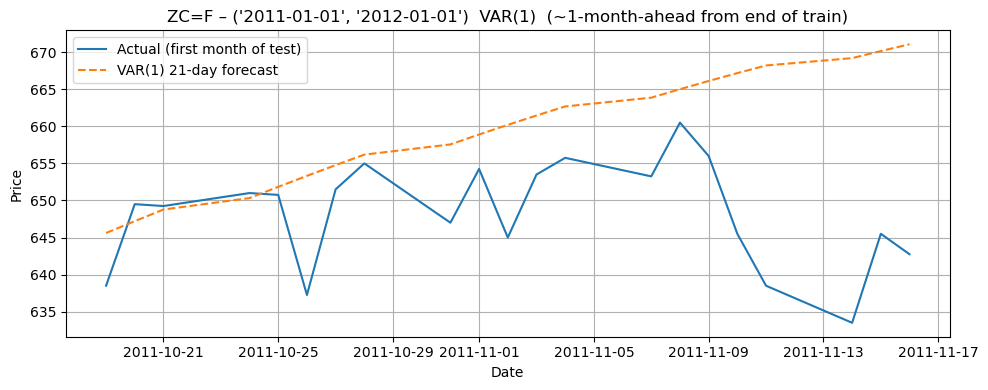

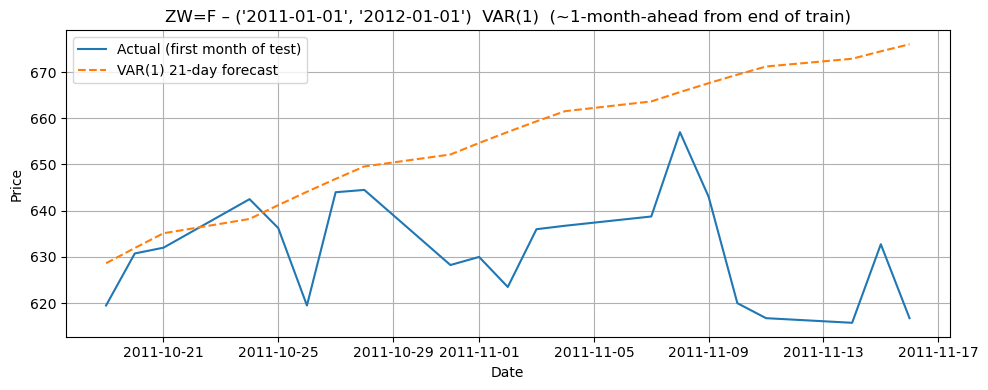

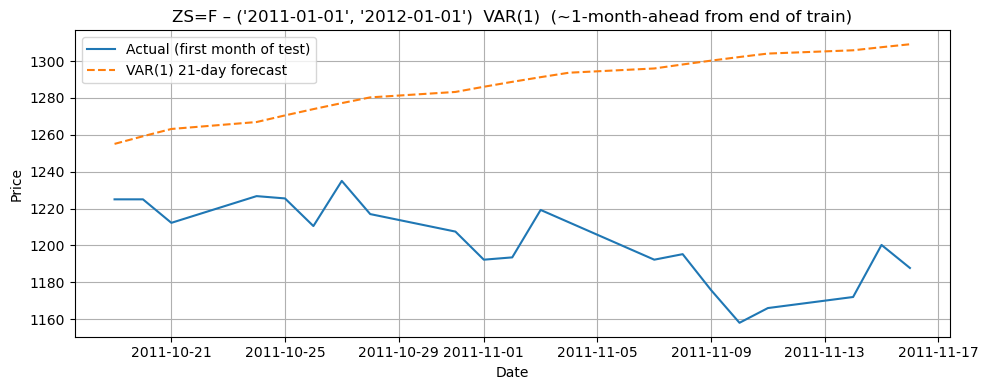


=== VAR month-ahead forecast: ('2012-01-01', '2013-01-01'), VAR(1) ===


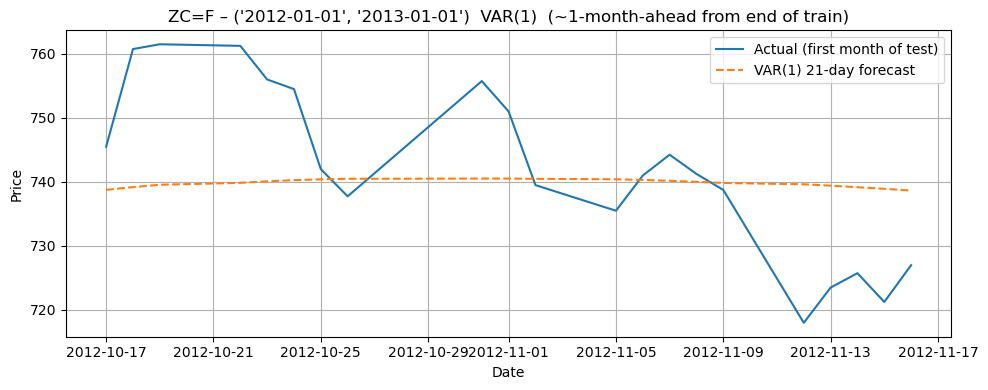

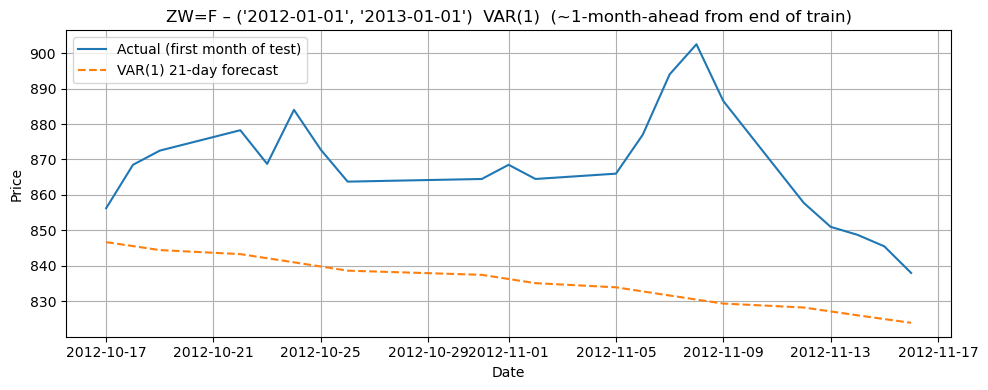

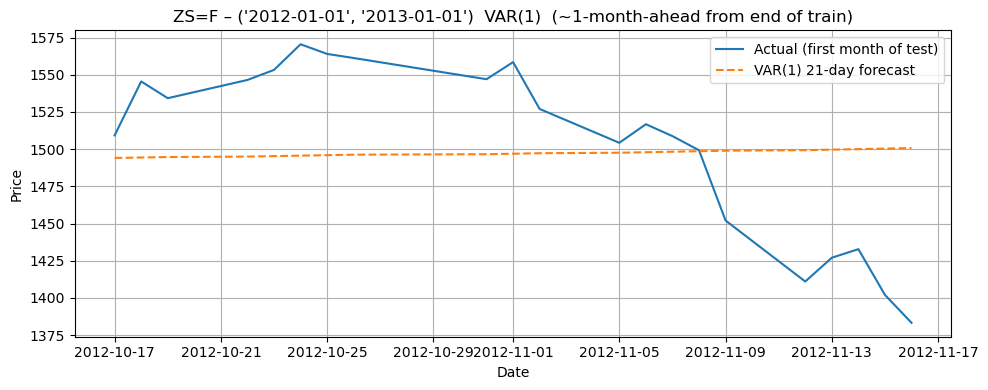


=== VAR month-ahead forecast: ('2013-01-01', '2014-01-01'), VAR(1) ===


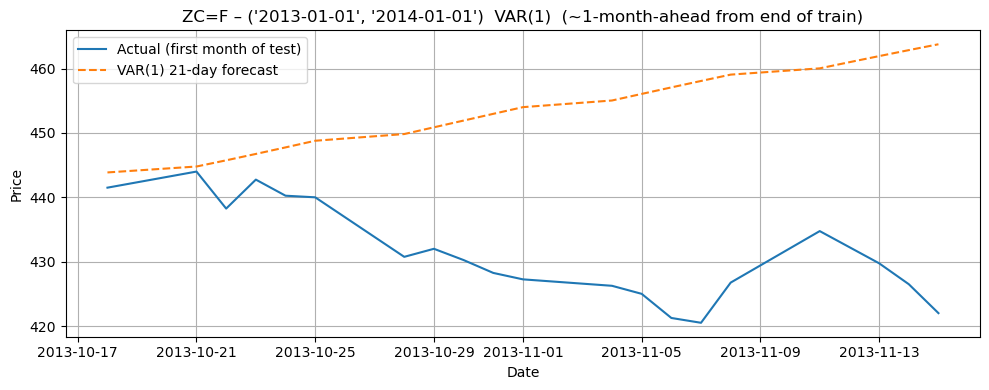

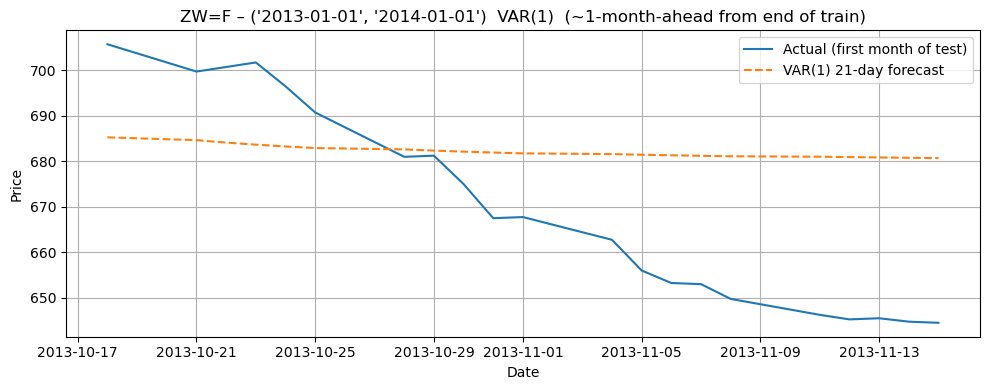

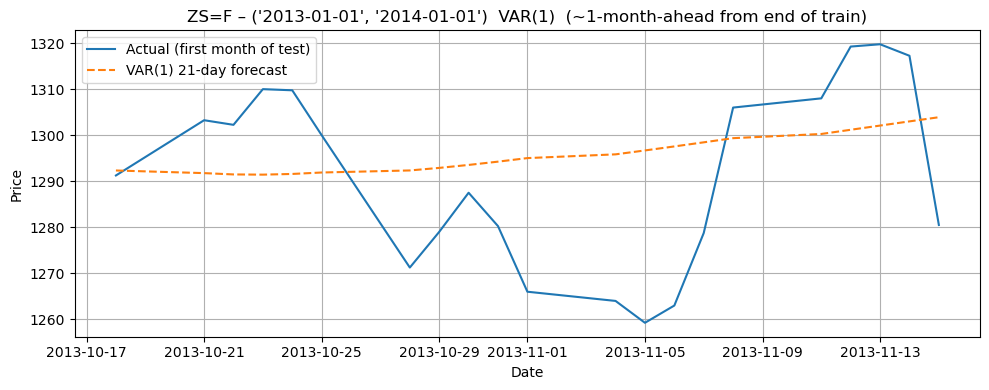


=== VAR month-ahead forecast: ('2014-01-01', '2015-01-01'), VAR(1) ===


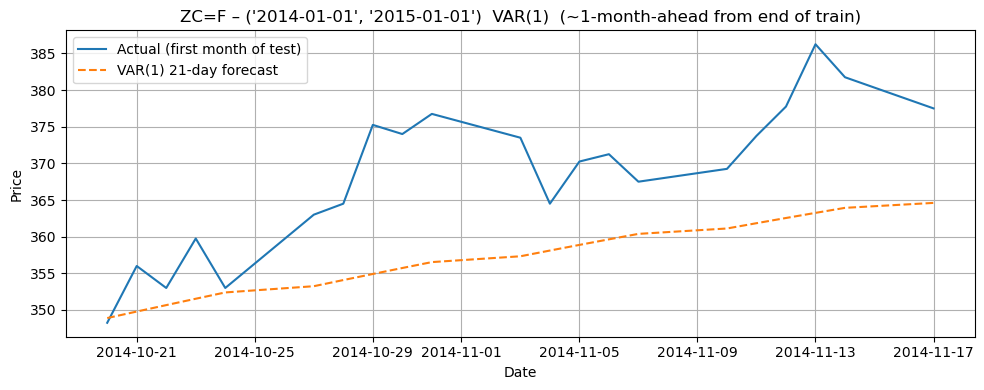

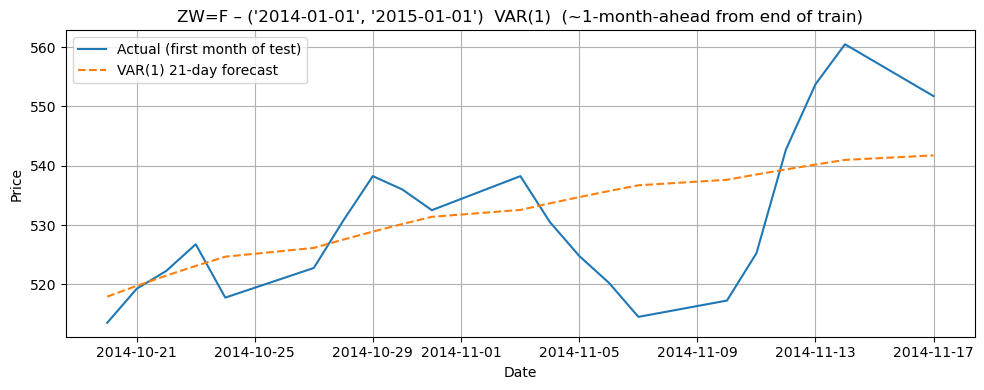

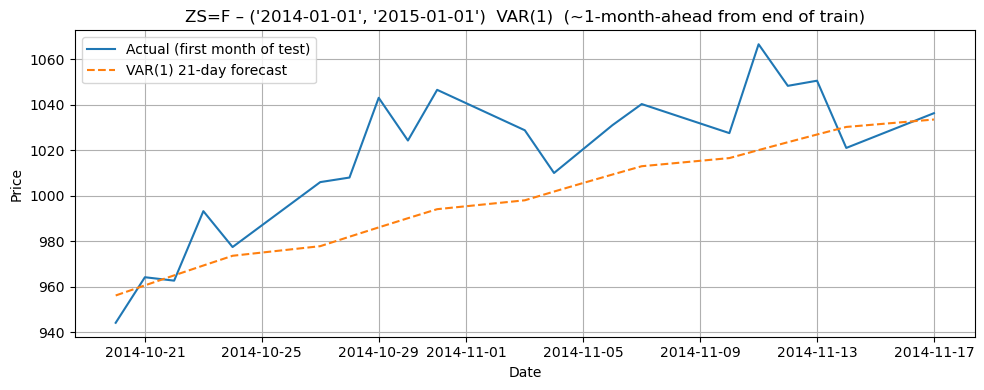


=== VAR month-ahead forecast: ('2015-01-01', '2016-01-01'), VAR(2) ===


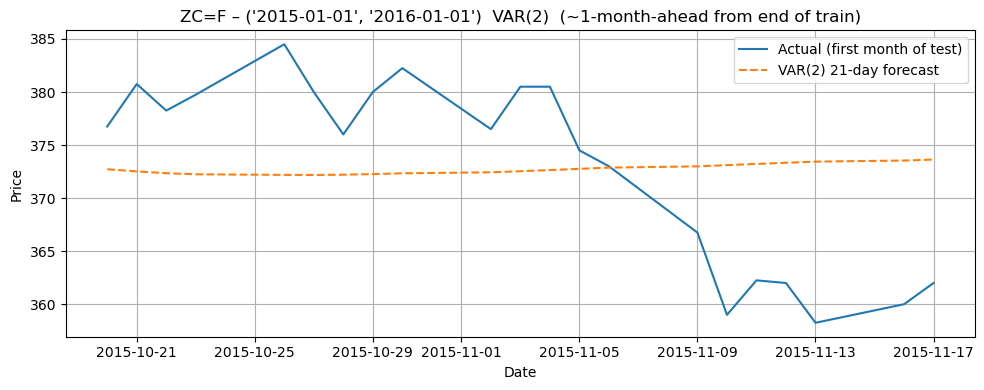

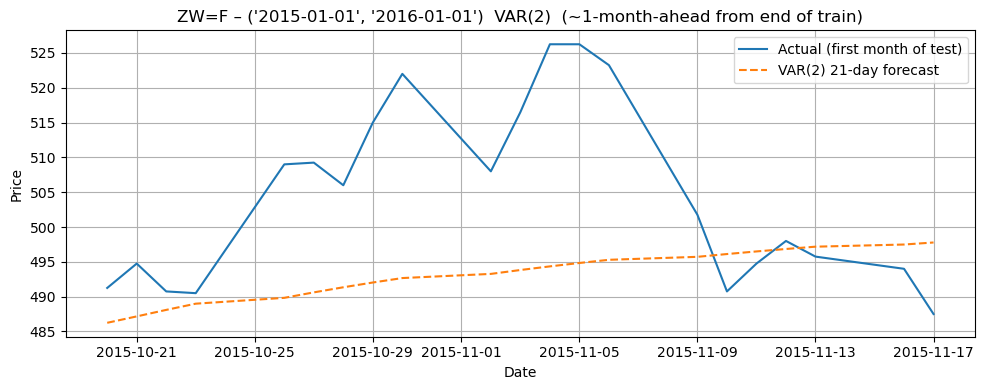

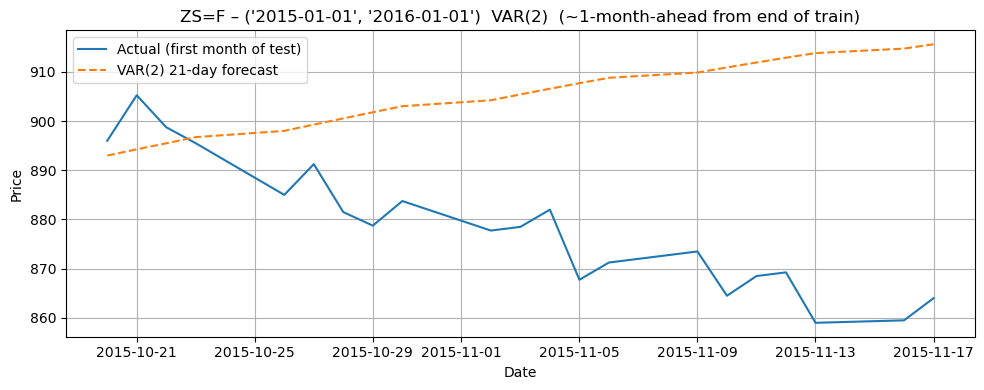


=== VAR month-ahead forecast: ('2016-01-01', '2017-01-01'), VAR(1) ===


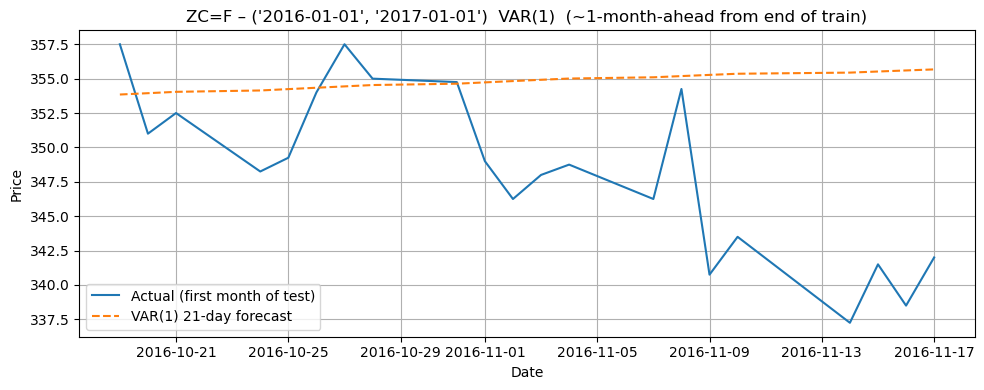

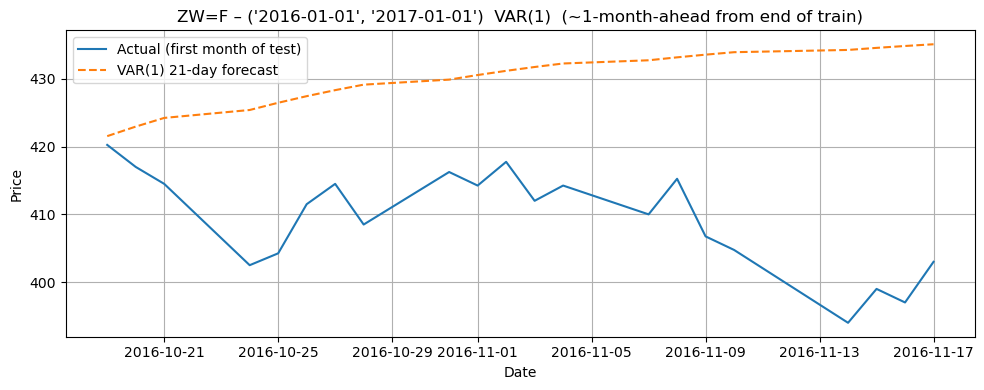

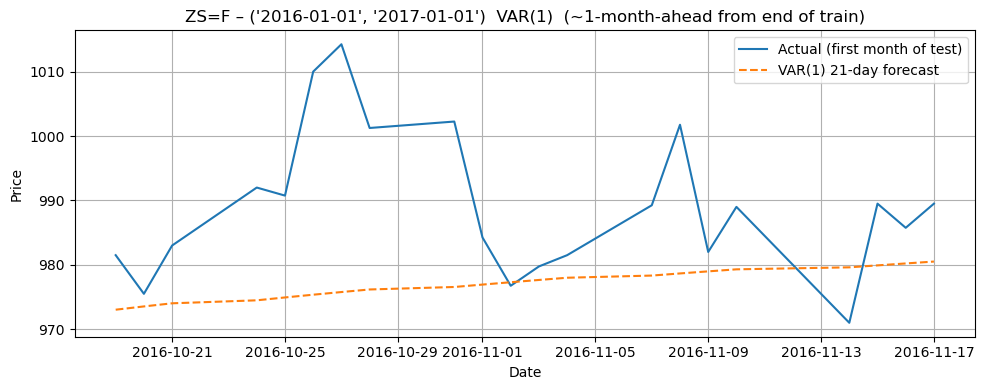


=== VAR month-ahead forecast: ('2017-01-01', '2018-01-01'), VAR(2) ===


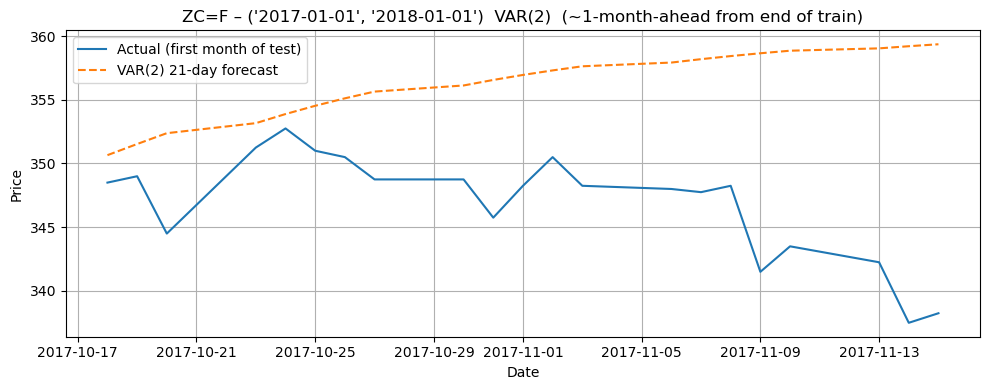

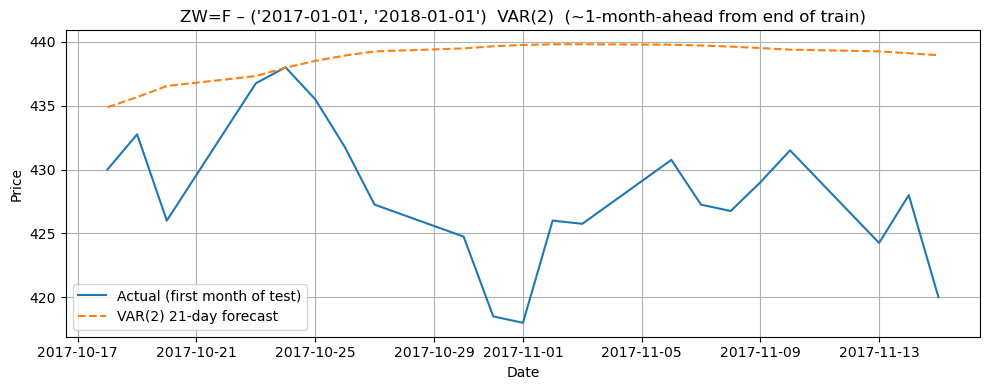

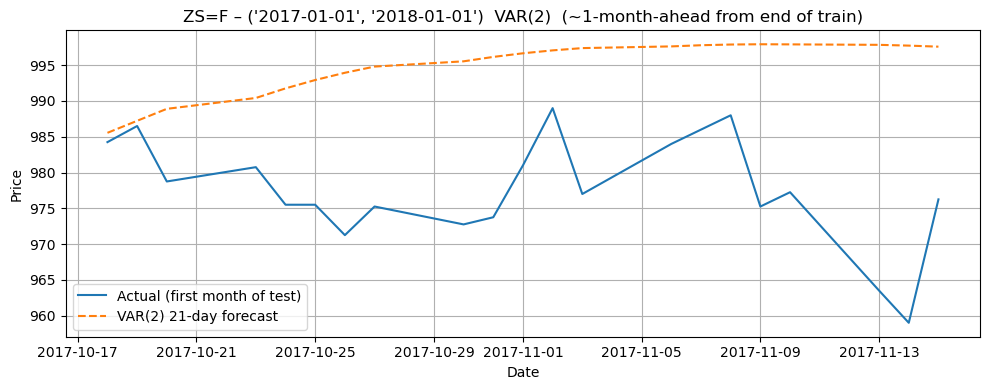


=== VAR month-ahead forecast: ('2018-01-01', '2019-01-01'), VAR(1) ===


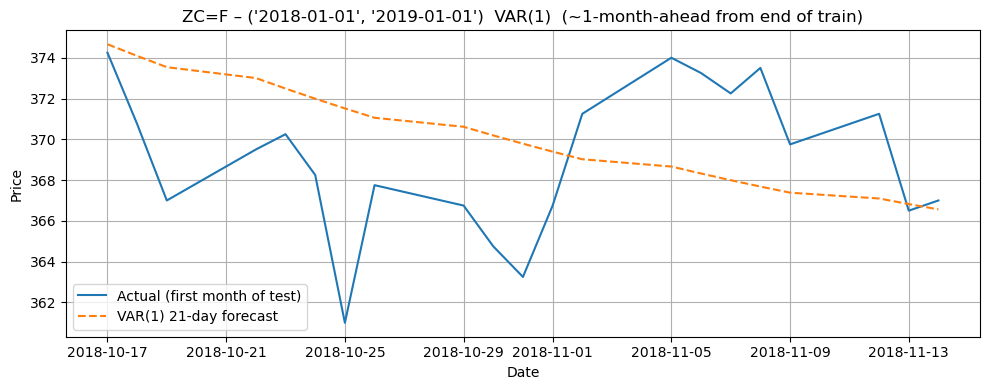

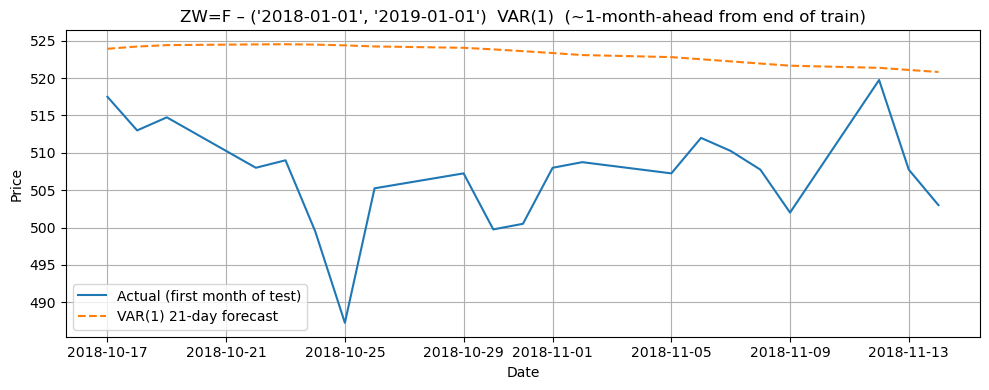

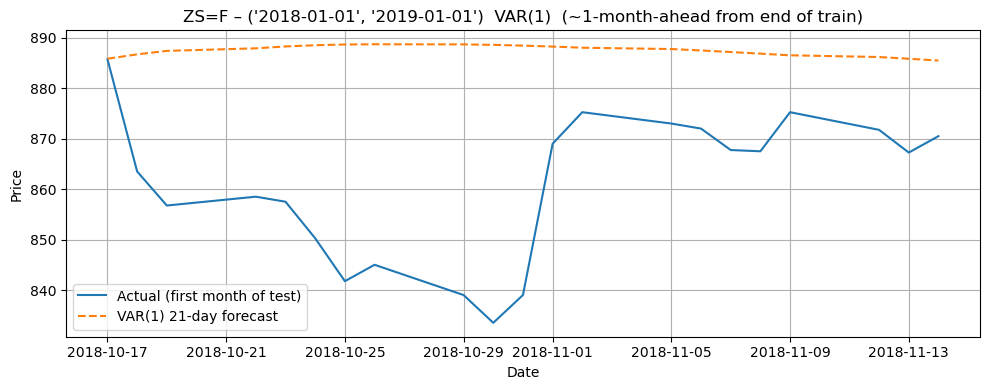


=== VAR month-ahead forecast: ('2019-01-01', '2020-01-01'), VAR(1) ===


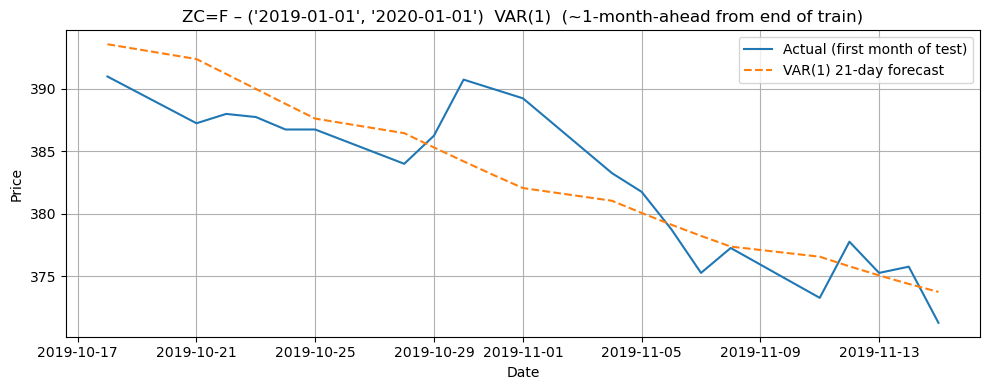

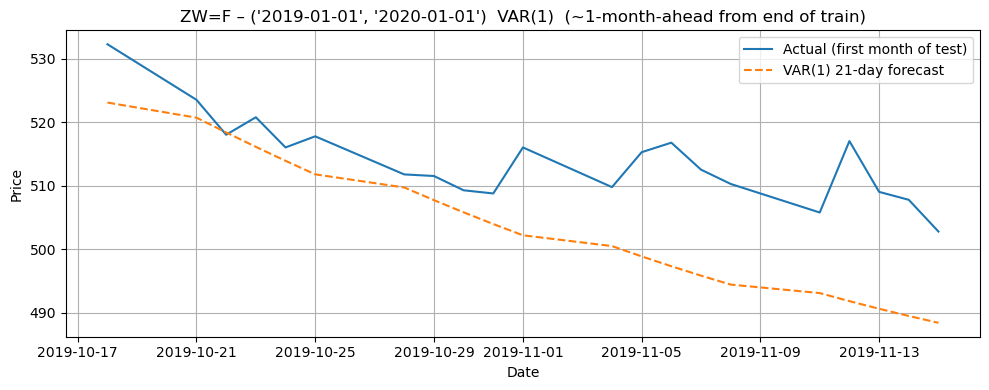

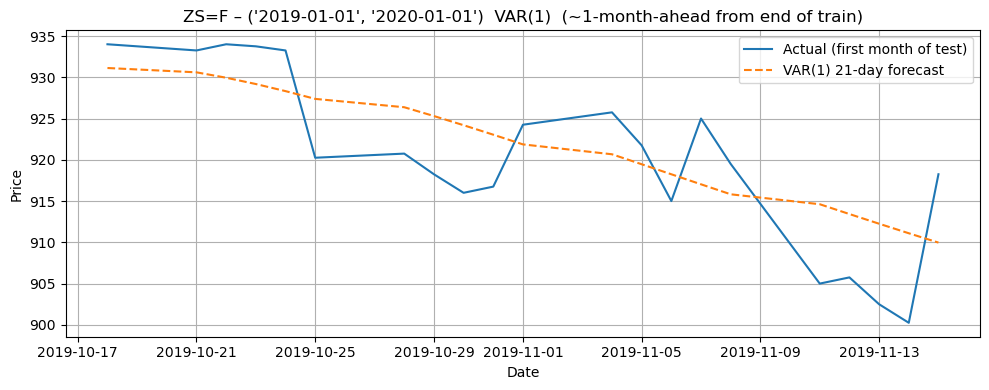


=== VAR month-ahead forecast: ('2020-01-01', '2021-01-01'), VAR(1) ===


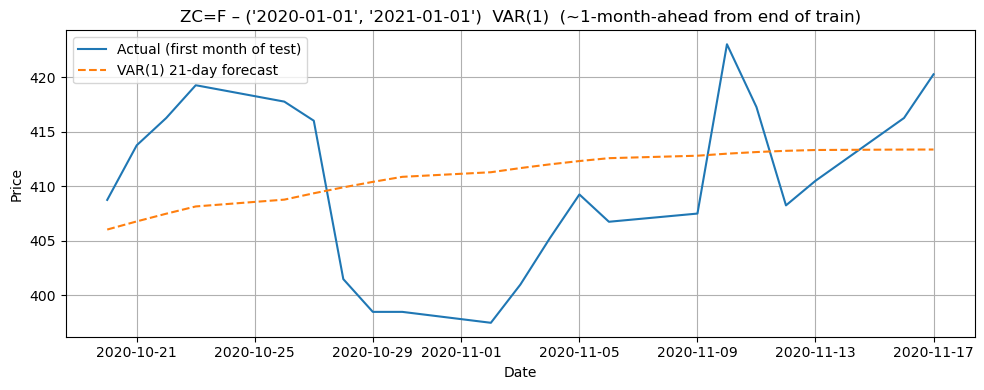

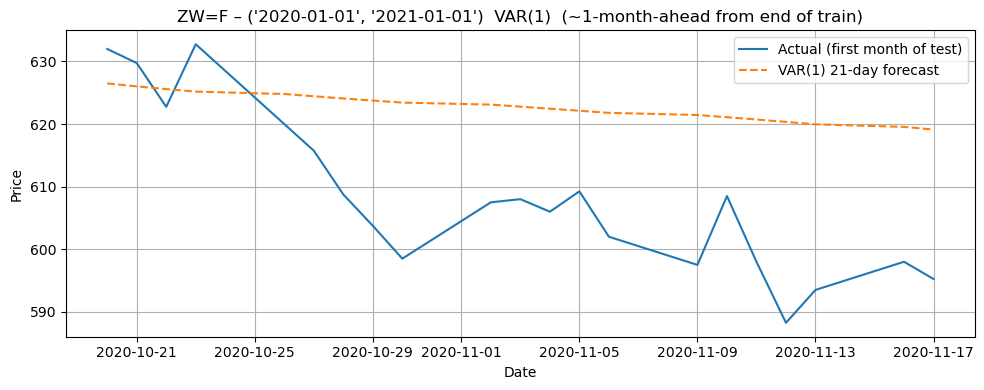

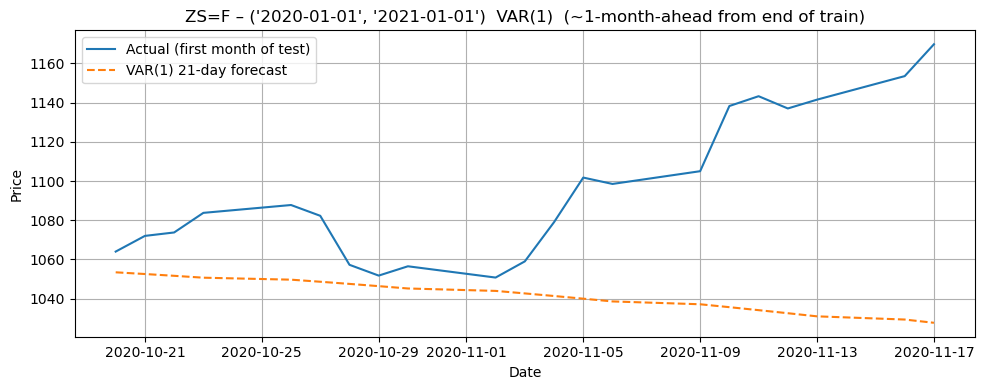


=== VAR month-ahead forecast: ('2021-01-01', '2022-01-01'), VAR(1) ===


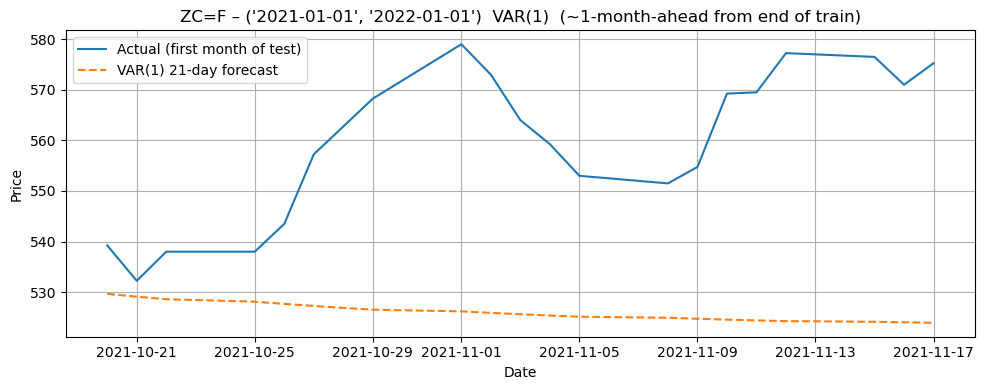

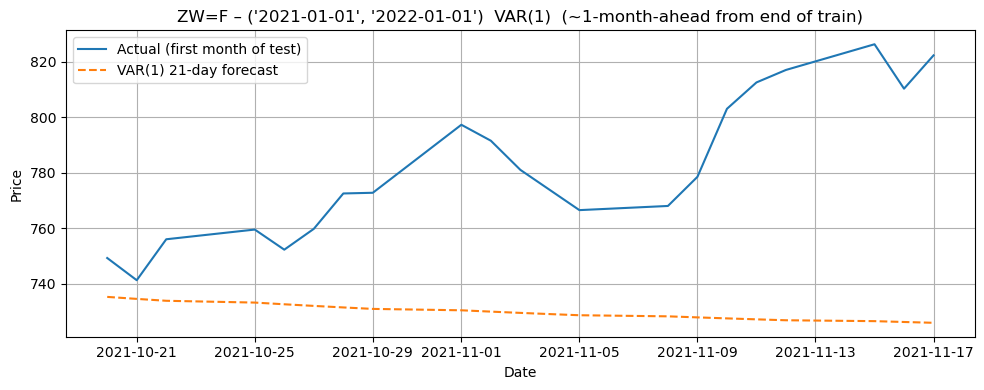

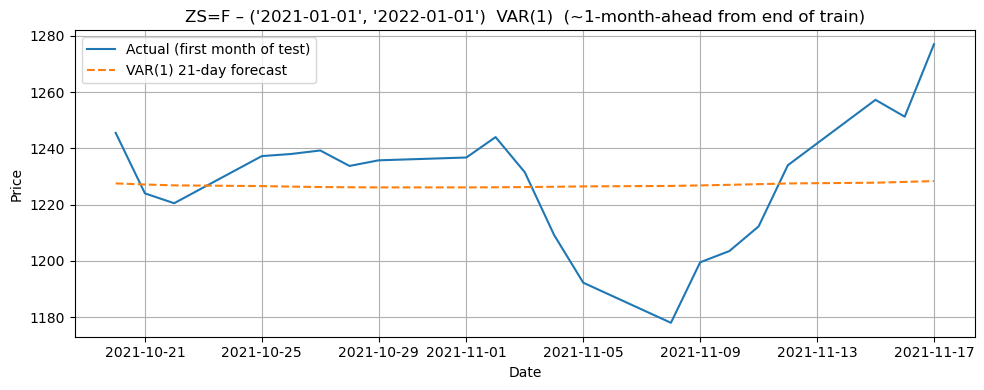


=== VAR month-ahead forecast: ('2022-01-01', '2023-01-01'), VAR(1) ===


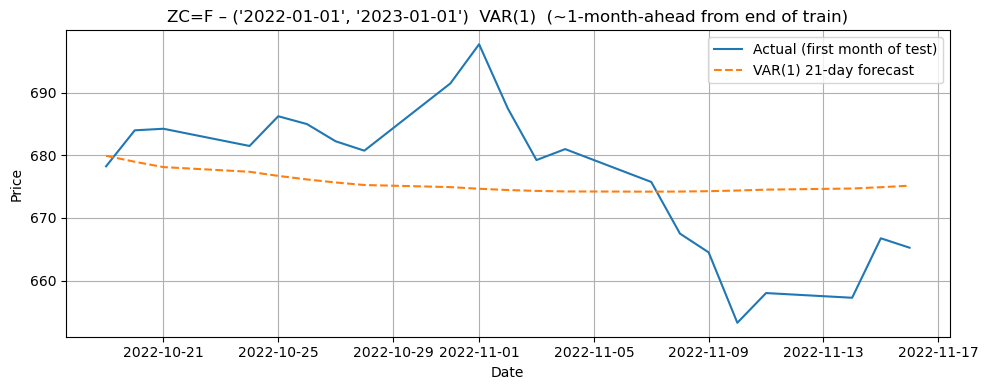

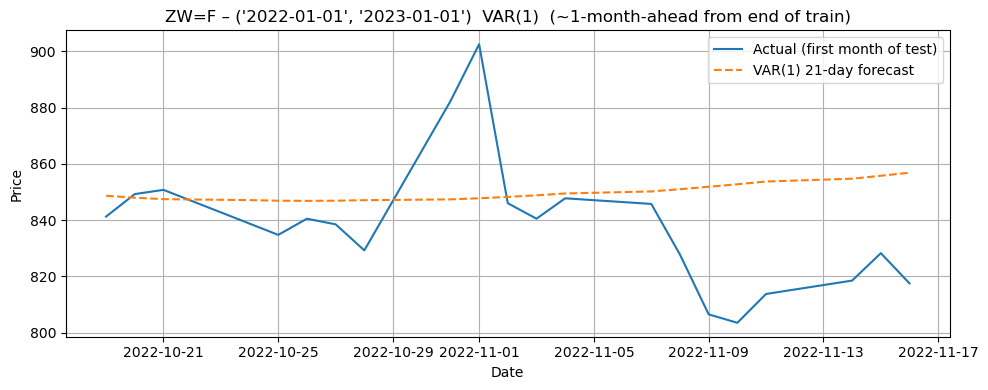

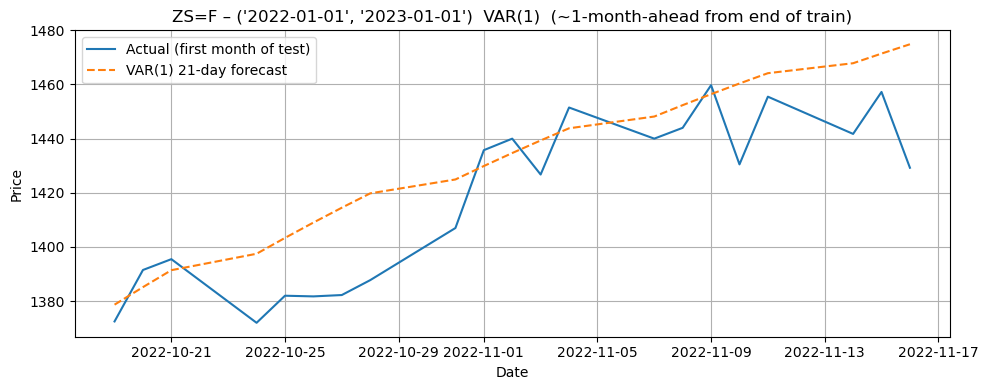


=== VAR month-ahead forecast: ('2023-01-01', '2024-01-01'), VAR(1) ===


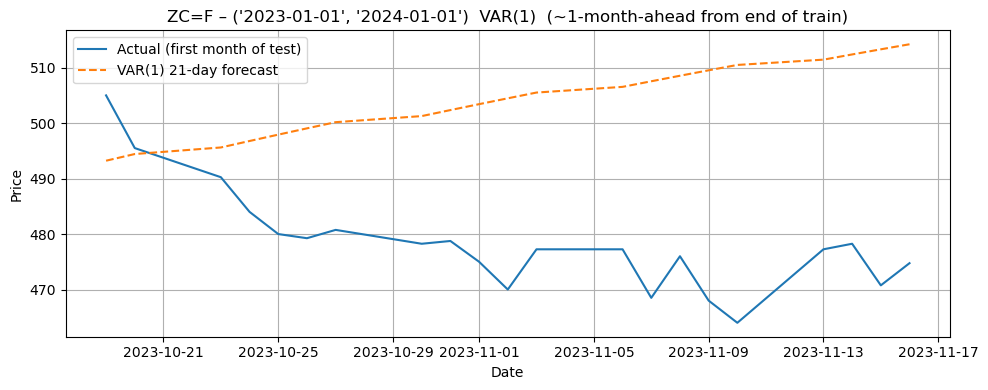

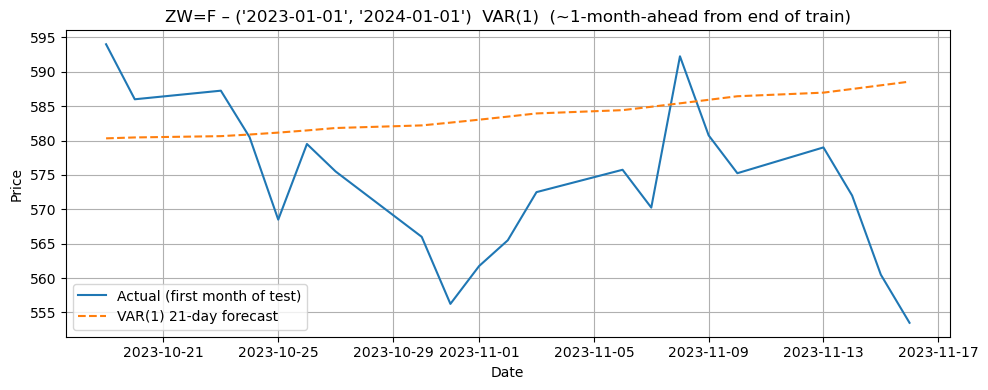

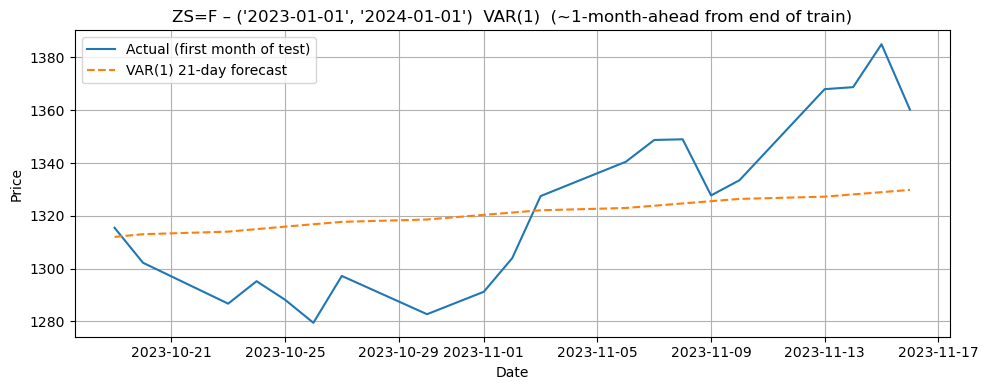


=== VAR month-ahead forecast: ('2024-01-01', '2025-01-01'), VAR(1) ===


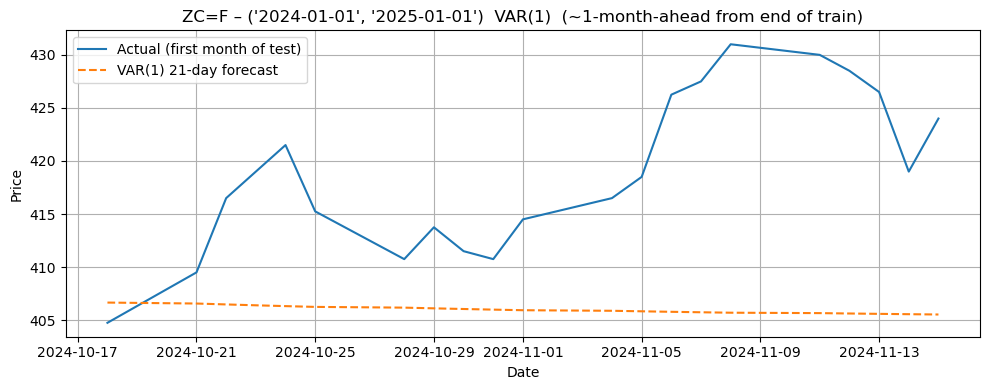

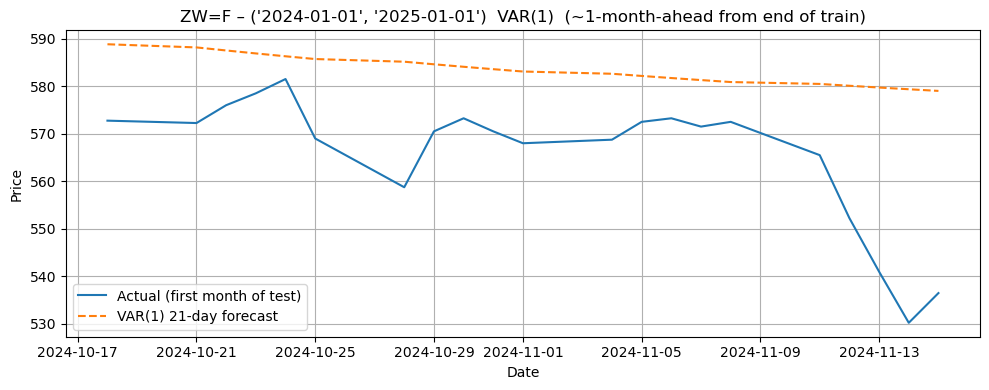

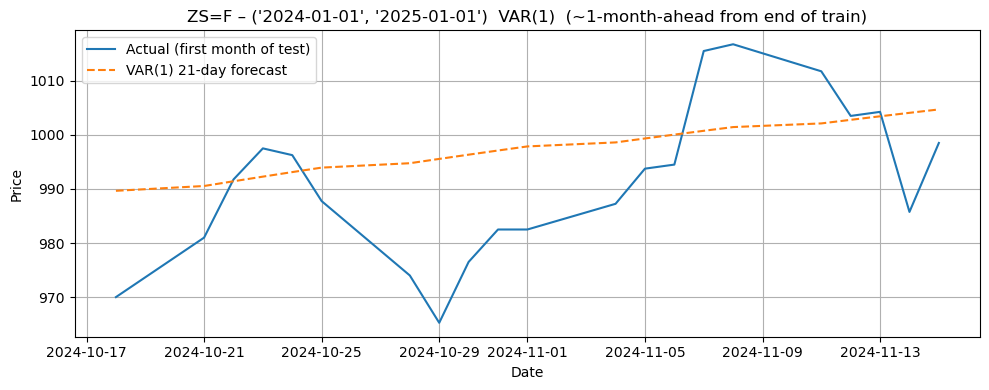

In [29]:
var_month_ahead_metrics = {}

for year in years_sorted:
    info = var_year_to_models[year]
    res = info["model"]
    p   = info["lag_order"]

    if res is None or p is None:
        print(f"\n=== Year {year}: no VAR model fitted, skipping ===")
        continue

    print(f"\n=== VAR month-ahead forecast: {year}, VAR({p}) ===")

    train_df = train_test_closes[year]['train'][tickers].dropna()
    test_df  = train_test_closes[year]['test'][tickers].dropna()

    if test_df.empty:
        print("  No test data, skipping.")
        continue

    steps = min(h, len(test_df))

    # last p observations from training to initialise VAR forecast
    last_y = train_df.values[-p:]   # shape (p, k) where k = len(tickers)

    # Multi-step forecast for all tickers
    fc_array = res.forecast(last_y, steps=steps)  # shape (steps, k)
    fc_df = pd.DataFrame(
        fc_array,
        index=test_df.index[:steps],
        columns=tickers,
    )

    var_month_ahead_metrics[year] = {}

    for ticker in tickers:
        y_true = test_df[ticker].iloc[:steps]
        y_pred = fc_df[ticker]

        # Metrics
        errors = y_pred - y_true
        rmse = np.sqrt(np.mean(errors**2))
        mae  = np.mean(np.abs(errors))
        me   = np.mean(errors)

        var_month_ahead_metrics[year][ticker] = {
            "lag_order": p,
            "rmse": rmse,
            "mae": mae,
            "me": me,
        }

        # Plot for this (year, ticker)
        plt.figure(figsize=(10, 4))
        plt.plot(y_true.index, y_true.values,
                 label="Actual (first month of test)")
        plt.plot(y_pred.index, y_pred.values, "--",
                 label=f"VAR({p}) {steps}-day forecast")
        plt.title(f"{ticker} – {year}  VAR({p})  (~1-month-ahead from end of train)")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        plt.close()


In [30]:
rows = []
for year, tickers_dict in var_month_ahead_metrics.items():
    for ticker, m in tickers_dict.items():
        rows.append({
            "year": year,
            "ticker": ticker,
            "lag_order": m["lag_order"],
            "rmse": m["rmse"],
            "mae":  m["mae"],
            "me":   m["me"],
        })

var_month_metrics_df = pd.DataFrame(rows)
var_month_metrics_df

year ticker  lag_order       rmse        mae  \
0   (2001-01-01, 2002-01-01)   ZC=F          2   3.448239   2.736469   
1   (2001-01-01, 2002-01-01)   ZW=F          2  22.273962  21.500268   
2   (2001-01-01, 2002-01-01)   ZS=F          2   4.320408   3.610546   
3   (2002-01-01, 2003-01-01)   ZC=F          1  14.089839  12.622949   
4   (2002-01-01, 2003-01-01)   ZW=F          1  10.536031   8.794081   
..                       ...    ...        ...        ...        ...   
67  (2023-01-01, 2024-01-01)   ZW=F          1  15.599108  13.000664   
68  (2023-01-01, 2024-01-01)   ZS=F          1  27.863305  24.316738   
69  (2024-01-01, 2025-01-01)   ZC=F          1  14.908560  13.021736   
70  (2024-01-01, 2025-01-01)   ZW=F          1  21.452758  17.908244   
71  (2024-01-01, 2025-01-01)   ZS=F          1  13.550232  11.104126   

           me  
0   -2.736469  
1  -21.500268  
2   -0.882764  
3   12.622949  
4    0.021233  
..        ...  
67   9.888368  
68   0.260998  
69 -12.840245  
70  17.908244  
71   6.348091  

[72 rows x 6 columns]